# Titanic 

# Todo
 - Manually group title field
 - Read through variable notes (e.g. add is_age_estimated feature)
 - Tune prediction threshlod (kept at 0.5 default atm)
 - EDA in general
 - More intelligent imputation
 - Outliers
 - Cluster features

In [1]:
from pathlib import Path
import os

is_titanic_dir = str(Path(os.getcwd())).rsplit("\\")[-1] == "Titanic"

if is_titanic_dir:
    os.chdir("../")

In [2]:
%%capture

import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
from xgboost import XGBClassifier

from mlutils.model.baseline import AutoMLBaseline
from mlutils.preprocess.missing import check_missingness
from mlutils.visualise.features import (
    feature_correlation_plot, 
    plot_importances, 
    plot_pct_by_group
)

### Load data

In [3]:
sns.set(rc={'figure.figsize':(10, 5)})

TARGET = "Survived"

DROP_COLS = [
    "PassengerId", 
    "Name",
]

In [4]:
# # Combine train and test into one data set for easy preprocessing
# def load_data(drop_cols=DROP_COLS):

In [5]:
def load_raw_data(data_set="train", drop_cols=None):

    if data_set == "test":
        df = pd.read_csv("Titanic/Data/test.csv")
        drop_cols = [x for x in DROP_COLS if x != "PassengerId"]
    else:
        df = pd.read_csv("Titanic/Data/train.csv")

    if drop_cols is not None:
        df.drop(drop_cols, axis=1, inplace=True)

    return df

In [6]:
df = load_raw_data(data_set="train", drop_cols=DROP_COLS)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


### Age

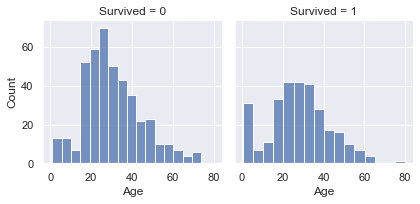

In [7]:
g = sns.FacetGrid(data=df, col="Survived")
g.map_dataframe(sns.histplot, data=df, x="Age",)

Ages are estimated if they are in the format XX.5 and greater than 1

In [8]:
def add_estimated_age(df):
    # Add estimated age flag
    is_estimated = (df["Age"] - round(df["Age"]) > 0) & (df["Age"] >= 1)
    df["age_is_estimated"] = np.where(is_estimated, 1, 0)
    return df

df = add_estimated_age(df)

In [9]:
print(f"{np.round(df['age_is_estimated'].sum() / len(df), 2)*100}% of ages are estimated")

2.0% of ages are estimated


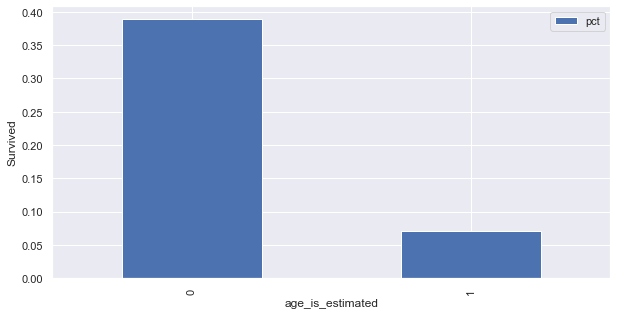

In [10]:
plot_pct_by_group(df, "Survived", "age_is_estimated", kind="bar")

### Cabin

The Cabin field consists of a single letter followed by a number.

It is assumed that the first letter indicates the area of the boat the cabin was in, and the number signifies room number within that area. The area of the boat the passenger was in could be informative of probability of survival.

In [11]:
df["Cabin"].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

Firstly extract the first letter and number. 

Then deal with missing data:
 - For the cabin_location: encode a field to indicate that it is missing as we cant reasonably impute
 - For the room number - impute with mean

In [12]:
def extract_cabin_features(df):
    # Create cabin location and number cols
    df["cabin_location"] = df["Cabin"].str.slice(0, 1)

    # Impute
    df["cabin_location"].fillna("M", inplace=True)
    df.drop("Cabin", axis=1, inplace=True)

    df["ticket_freq"] = df.groupby("Ticket")["Ticket"].transform("count")
    df.drop("Ticket", axis=1, inplace=True)

    return df
df = extract_cabin_features(df)

# Group these?

<AxesSubplot:xlabel='cabin_location', ylabel='Survived'>

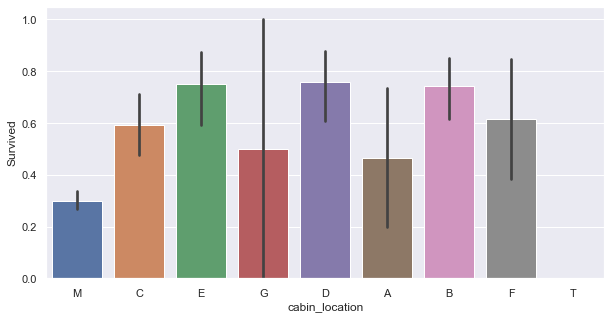

In [13]:
sns.barplot(data=df, x="cabin_location", y="Survived")

Looks like the imputed cabin number isn't going to add anything useful, so remove this

### Pclass

1st = Upper  
2nd = Middle  
3rd = Lower

In [14]:
def pclass_to_char(df):
    pclass_map = {
        1: "upper",
        2: "middle",
        3: "lower"
    }

    df["Pclass"] = df["Pclass"].apply(lambda x: pclass_map[x])
    return df
df = pclass_to_char(df)

**Missingness**

In [15]:
check_missingness(df)

,pct_missing
Age,19.87
Embarked,0.22


In [16]:
def impute_data(df: pd.DataFrame) -> pd.DataFrame:
    # Impute embarked with mode for now
    mode_imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    df[['Embarked']] = mode_imputer.fit_transform(df[['Embarked']])

    # Impute age with median
    median_imputer = SimpleImputer(missing_values=np.nan, strategy="median")
    df["Age"] = median_imputer.fit_transform(df[["Age"]])

    return df
    
df = impute_data(df)

**Encode categorical variables**

In [17]:
def ohe(df):
    return pd.get_dummies(df, drop_first=True)
df = ohe(df)

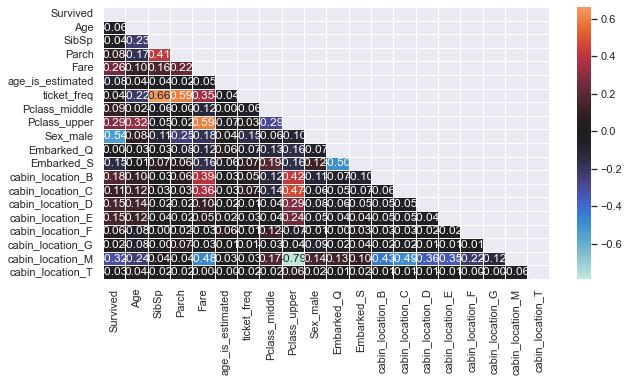

In [18]:
feature_correlation_plot(df)

**Class imbalance**

In [19]:
pct_positive = len(df.loc[df[TARGET] == 1]) / len(df) * 100
pct_positive

38.38383838383838

**X, y**

In [20]:
X, y = df.drop(TARGET, axis=1), df[TARGET]

### Basline model

In [21]:
%%capture
baseline_performance = AutoMLBaseline(X, y, scoring="accuracy", n_cv=3).run_experiment()

In [22]:
baseline_performance

,score
XGBClassifier,0.810325
LogisticRegression,0.809203
MLPClassifier,0.806958
RandomForestClassifier,0.784512
GaussianNB,0.735129
SVC,0.664422
DummyClassifier,0.616162


### XGBoost

Tune xgboost model

In [27]:
# %%capture

# xgb = XGBClassifier(scale_pos_weight = (100 - pct_positive) / pct_positive)

# params = {
#     "max_depth": [3, 6, 9, 12],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "n_estimators": [100, 500, 1000, 1500],
#     "colsample_bytree": [0.3, 0.5, 0.75]
# }

# stratified_kfold = StratifiedKFold(n_splits=3)

# clf = GridSearchCV(estimator=xgb, 
#                    param_grid=params,
#                    scoring='accuracy', 
#                    verbose=1,
#                    n_jobs=-1,
#                    cv=stratified_kfold)

# clf.fit(X, y)
# xgb_tuned = clf.best_estimator_

In [28]:
# print(f"Best score {round(clf.best_score_, 3)}")
# print(f"Best params {clf.best_params_}")

# plot_importances(clf.best_estimator_, X.columns, 15)

In [24]:
%%capture

from sklearn.model_selection import cross_val_score

xgb = XGBClassifier(max_depth=3, scale_pos_weight = (100 - pct_positive) / pct_positive)
cv_score = cross_val_score(xgb, X, y, scoring="accuracy").mean()
xgb.fit(X, y)

**Tune model cutoff**

Perform kfolds and for each fold return the highest accuracy probability cutoff

In [32]:
%%capture

from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

k_splits = KFold(n_splits=3).split(X)

cutoffs = np.arange(0, 101, 1) / 100
best_cutoffs = []

for train_idx, test_idx in k_splits:
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    accuracies = {}
    xgb_ = clone(xgb)

    for cutoff in cutoffs:
        xgb_.fit(X_train, y_train)
        raw_preds = xgb_.predict_proba(X_test)[:, 1]
        accuracies[cutoff] = accuracy_score(y_test, np.where(raw_preds > cutoff, 1, 0))
    # Get first best scoring cutoff
    best_cutoff = [k for k, v in accuracies.items() if v == max(accuracies.values())][0]
    best_cutoffs.append(best_cutoff)

0.8294143493817087


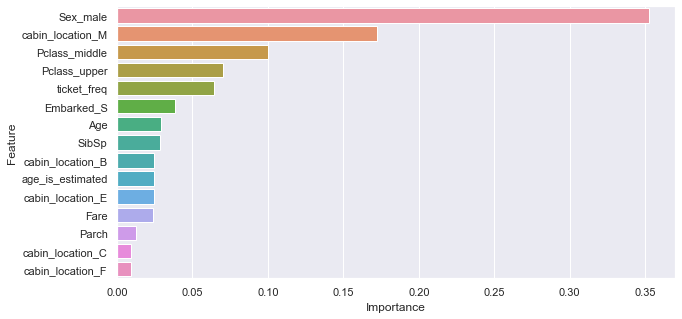

In [34]:
print(cv_score)
plot_importances(xgb, X.columns, 15)

### Score test set and submit

In [38]:
df_test = load_raw_data("test", DROP_COLS)
df_test = extract_cabin_features(df_test)
df_test = add_estimated_age(df_test)
df_test = pclass_to_char(df_test)
df_test = impute_data(df_test)
df_test = ohe(df_test)

# Add in additional features if groups missing from test set 
missing_features = list(
    set(X) -
    set(df_test.drop("PassengerId", axis=1).columns)
)
print(f"Adding missing features to test set: {missing_features}")

for missing_feature in missing_features:
    df_test[missing_feature] = 0

Adding missing features to test set: ['cabin_location_T']


In [59]:
%%capture
y_hats = df_test[["PassengerId"]]
y_hats["Survived"] = xgb.predict(df_test.drop("PassengerId", axis=1))
y_hats.to_csv("Titanic/Data/test_predictions.csv", index=False)